# Testing Numerical Algorithms Solving LASSO

In [2]:
ISTA_solver <- function(X, y, lambda, max_iter, tol) {
  beta <- rep(0, ncol(X))
  obj <- numeric(max_iter)
  L <- norm(X, "2")^2
  start_time <- Sys.time()
  for (iter in 1 : max_iter) {
    beta_new <- soft_thresh(beta + t(X) %*% (y - X %*% beta) / L, lambda / L)
    obj[iter] <- 0.5 * norm(X %*% beta_new - y, "F")^2 + lambda * sum(abs(beta_new))

    if (iter > 1 && abs(obj[iter] - obj[iter - 1]) < tol) {
      return(list(beta = beta_new, convergence = TRUE, iter = iter,
                  obj = obj[1 : iter], time = Sys.time() - start_time))
    }
    beta <- beta_new
  }
  return(list(beta = beta, convergence = TRUE, iter = max_iter, obj = obj,
              time = Sys.time() - start_time))
}

soft_thresh <- function(x, lambda) {
  sign(x) * pmax(abs(x) - lambda, 0)
}

In [3]:
FISTA_solver <- function(X, y, lambda, max_iter, tol = 1e-6) {
  beta <- rep(0, ncol(X))
  z <- beta
  t <- 1
  obj <- numeric(max_iter)
  L <- norm(X, "2")^2
  start_time <- Sys.time()

  for (iter in 1 : max_iter) {
    beta_old <- beta
    z <- z + t(X) %*% (y - X %*% z) / L
    beta_new <- soft_thresh(z, lambda / L)
    t_old <- t
    t <- (1 + sqrt(1 + 4 * t^2)) / 2
    z <- beta_new + ((t_old - 1) / t) * (beta_new - beta_old)
    obj[iter] <- 0.5 * norm(X %*% beta_new - y, "F")^2 + lambda * sum(abs(beta_new))

    # Check convergence
    if (sqrt(sum((beta_new - beta)^2)) < tol) {
      return(list(beta = beta_new, convergence = TRUE, iter = iter,
                  obj = obj[1 : iter], time = Sys.time() - start_time))
    }
    beta <- beta_new
  }

  return(list(beta = beta, convergence = TRUE, iter = max_iter, obj = obj,
              time = Sys.time() - start_time))
}

soft_thresh <- function(x, lambda) {
  sign(x) * pmax(abs(x) - lambda, 0)
}

In [4]:
CGDA_solver <- function(X, y, lambda, max_iter = 1000, tol = 1e-6) {

  n <- nrow(X)
  p <- ncol(X)

  # Precompute X'X and X'y
  XtX <- crossprod(X)
  Xty <- crossprod(X, y)

  # Initialize beta
  beta <- rep(0, p)  # β^(0)

  # Soft-thresholding function
  soft_threshold <- function(z, gamma) {
    sign(z) * pmax(0, abs(z) - gamma)
  }

  start_time <- Sys.time()
  # CGDA Iterations
  for (iter in 1:max_iter) {
    beta_prev <- beta

    # Coordinate-wise updates
    for (j in 1:p) {
      # Compute the partial residual
      r_j <- Xty[j] - sum(XtX[j, -j] * beta[-j])

      # Update β_j^(k+1)
      beta[j] <- soft_threshold(r_j / n, lambda) / (XtX[j, j] / n)
    }

    # Check convergence
    if (sqrt(sum((beta - beta_prev)^2)) < tol) {
      return(list(beta = beta, iter = iter, convergence = TRUE,
                  time = Sys.time() - start_time))
    }
  }

  # Return results
  return(list(beta = beta, iter = max_iter, convergence = FALSE,
              time = Sys.time() - start_time))
}

In [10]:
SLA_solver <- function(X, y, lambda, alpha = 10, max_iter = 1000, tol = 1e-6) {
  # Dimensions
  n <- nrow(X)
  p <- ncol(X)

  # Precompute constants
  XtX <- crossprod(X) / n       # X'X / n
  Xty <- crossprod(X, y) / n    # X'y / n
  sigma_max_sq <- max(eigen(XtX, symmetric = TRUE, only.values = TRUE)$values)
  mu <- 1 / (sigma_max_sq + lambda * alpha / 2)

  # Define the correct gradient of the surrogate function (∇φα)
  surrogate_gradient <- function(beta) {
    grad <- tanh(alpha * beta / 2)
    return(grad)
  }

  # Initialization
  beta <- rep(0, p)  # β^(0)
  beta_prev <- rep(0, p)  # β^(−1)
  start_time <- Sys.time()
  # Iterative SLA optimization
  for (iter in 1:max_iter) {
    # Extrapolated step
    w <- beta + (iter - 2) / (iter + 1) * (beta - beta_prev)

    # Gradient calculation
    gradient <- XtX %*% w - Xty + lambda * surrogate_gradient(w)

    # Update step
    beta_new <- w - mu * gradient

    # Check convergence
    if (sqrt(sum((beta_new - beta)^2)) < tol) {
      return(list(beta = beta_new, iter = iter, convergence = TRUE,
                  time = Sys.time() - start_time))
    }

    # Update variables for the next iteration
    beta_prev <- beta
    beta <- beta_new
  }

  # Return results if not converged within max_iter
  return(list(beta = beta, iter = max_iter, convergence = FALSE,
              time = Sys.time() - start_time))
}

In [11]:
# Simulate data for sparse solutions
set.seed(9248)
m <- 500
n <- 2000
X <- matrix(rnorm(m * n), nrow = m)
x0 <- runif(n)
x0[x0 < 0.9] <- 0
y <- X %*% x0 + rnorm(m)
lambda <- 0.5

In [12]:
# Compute R^2
calculate_r_squared <- function(y, y_pred) {
  ss_total <- sum((y - mean(y))^2)  # Total sum of squares
  ss_residual <- sum((y - y_pred)^2)  # Residual sum of squares
  r_squared <- 1 - (ss_residual / ss_total)
  return(r_squared)
}

# Residual Plot
plot_residuals <- function(y, y_pred, r_squared, title) {
  residuals <- y - y_pred
  plot(residuals, main = title,
       xlab = "Index", ylab = "Residuals", col = "blue", pch = 16)
  abline(h = 0, col = "red", lwd = 2)
  legend("topright", legend = paste("R^2 =", round(r_squared, 3)), bty = "n", cex = 1.2)
}

In [13]:
# Run ISTA
result_ista <- ISTA_solver(X, y, lambda, max_iter = 1000, tol = 1e-5)
beta_ista <- result_ista$beta
y_pred_ista <- X %*% beta_ista

# Run FISTA
result_fista <- FISTA_solver(X, y, lambda, max_iter = 1000, tol = 1e-5)
beta_fista <- result_fista$beta
y_pred_fista <- X %*% beta_fista

# Run CGDA
result_cgda <- CGDA_solver(X, y, lambda, max_iter = 1000, tol = 1e-5)
beta_cgda <- result_cgda$beta
y_pred_cgda <- X %*% beta_cgda

# Run SLA
result_sla <- SLA_solver(X, y, lambda, alpha = 10, max_iter = 1000, tol = 1e-6)
beta_sla <- result_sla$beta
y_pred_sla <- X %*% beta_sla

if (!requireNamespace("genlasso", quietly = TRUE)) {
  install.packages("genlasso")
}
library(genlasso)

# Run PFA
result_pfa <- genlasso(y, X, diag(n), maxsteps = 1000, rtol = 1e-5, btol = 1e-5)
beta_pfa <- result_pfa$beta[, 1000]
y_pred_pfa <- X %*% beta_pfa

if (!requireNamespace("glmnet", quietly = TRUE)) {
  install.packages("glmnet")
}
library(glmnet)

# Run glmnet
fit_glmnet <- glmnet(X, y, alpha = 1, lambda = lambda, intercept = TRUE)
beta_glmnet <- as.vector(coef(fit_glmnet, s = lambda))  # Include intercept term
y_pred_glmnet <- predict(fit_glmnet, X, s = lambda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’


Loading required package: Matrix

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message in genlasso(y, X, diag(n), maxsteps = 1000, rtol = 1e-05, btol = 1e-05):
“Adding a small ridge penalty (multiplier 0.0001), because X has more columns than rows.”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loaded glmnet 4.1-8



In [14]:
r_squared_ista <- calculate_r_squared(y, y_pred_ista)
r_squared_fista <- calculate_r_squared(y, y_pred_fista)
r_squared_cgda <- calculate_r_squared(y, y_pred_cgda)
r_squared_sla <- calculate_r_squared(y, y_pred_sla)
r_squared_pfa <- calculate_r_squared(y, y_pred_pfa)
r_squared_glmnet <- calculate_r_squared(y, y_pred_glmnet)

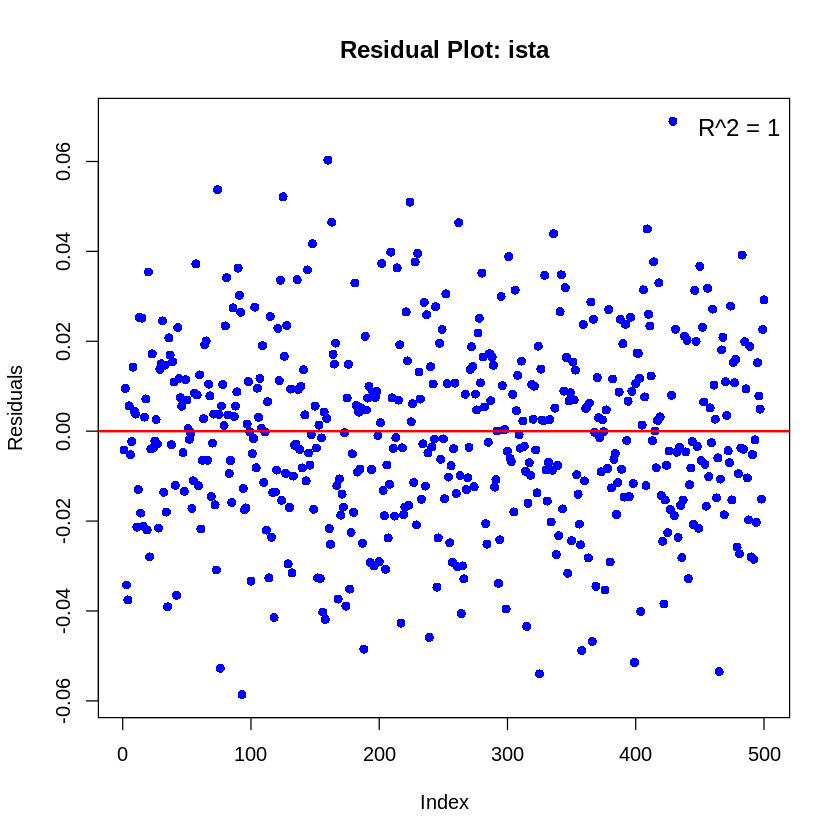

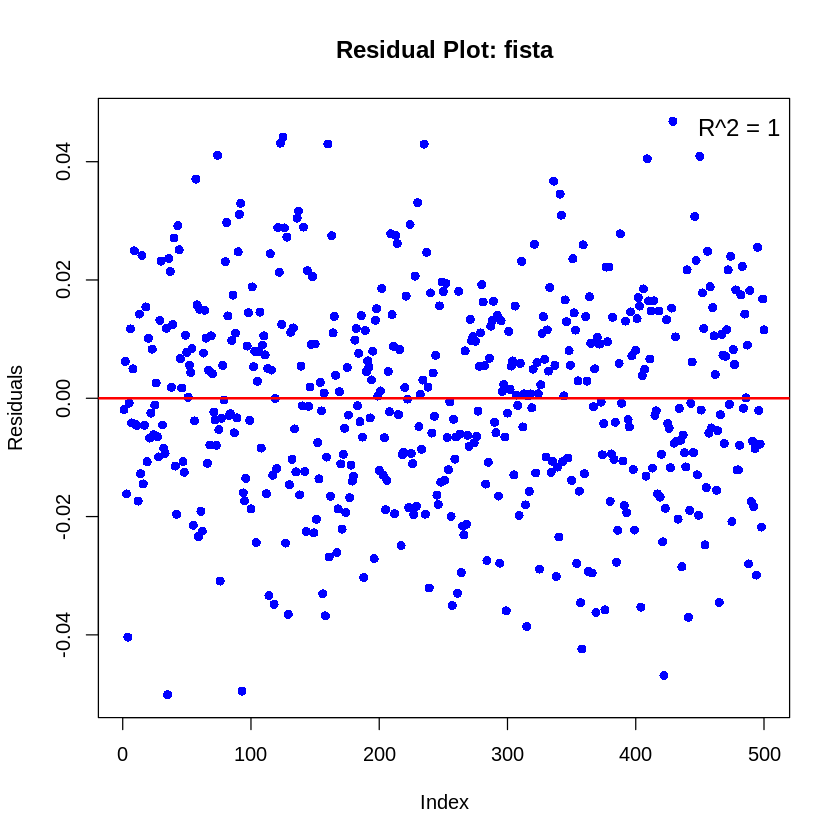

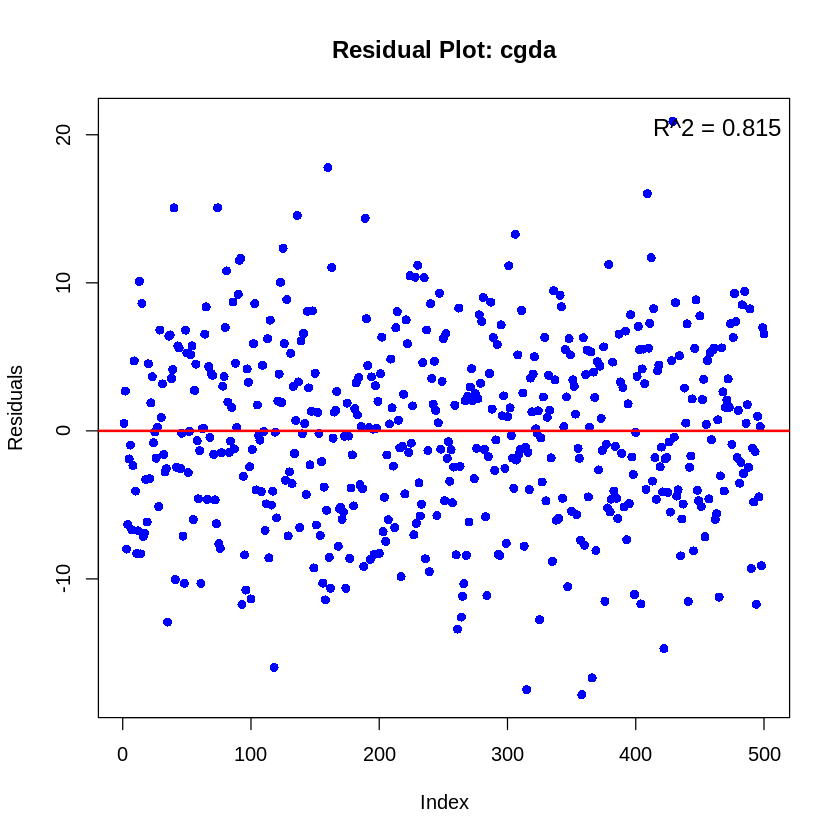

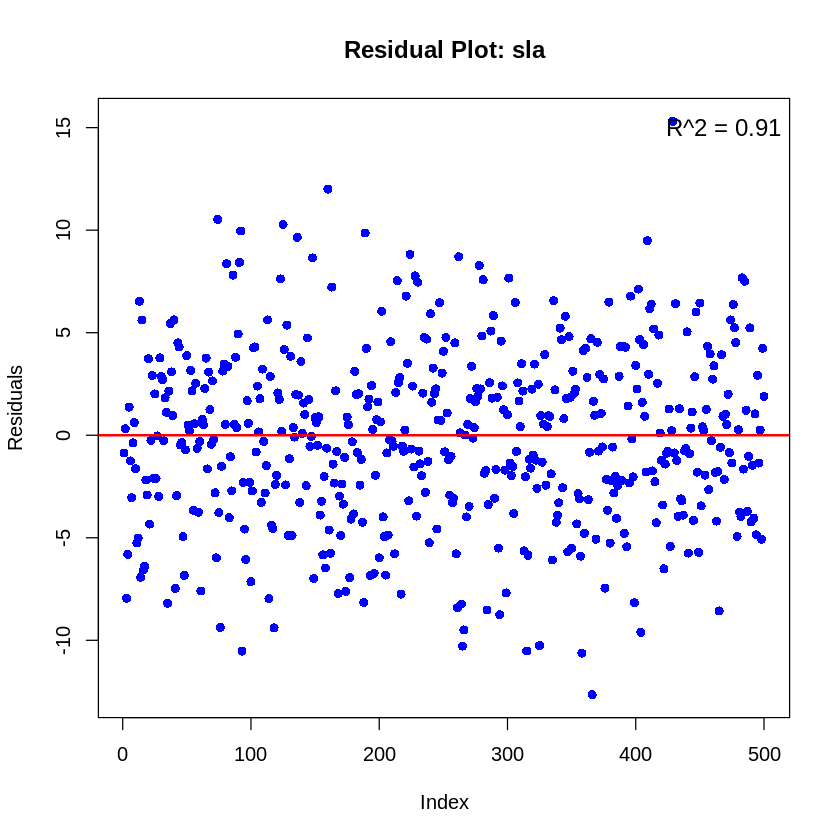

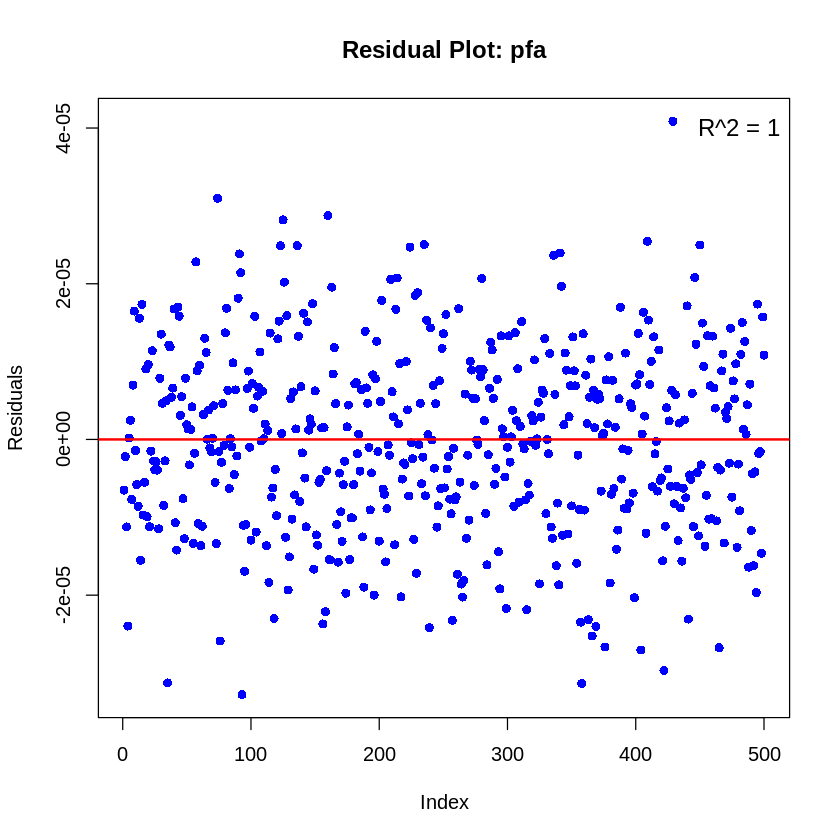

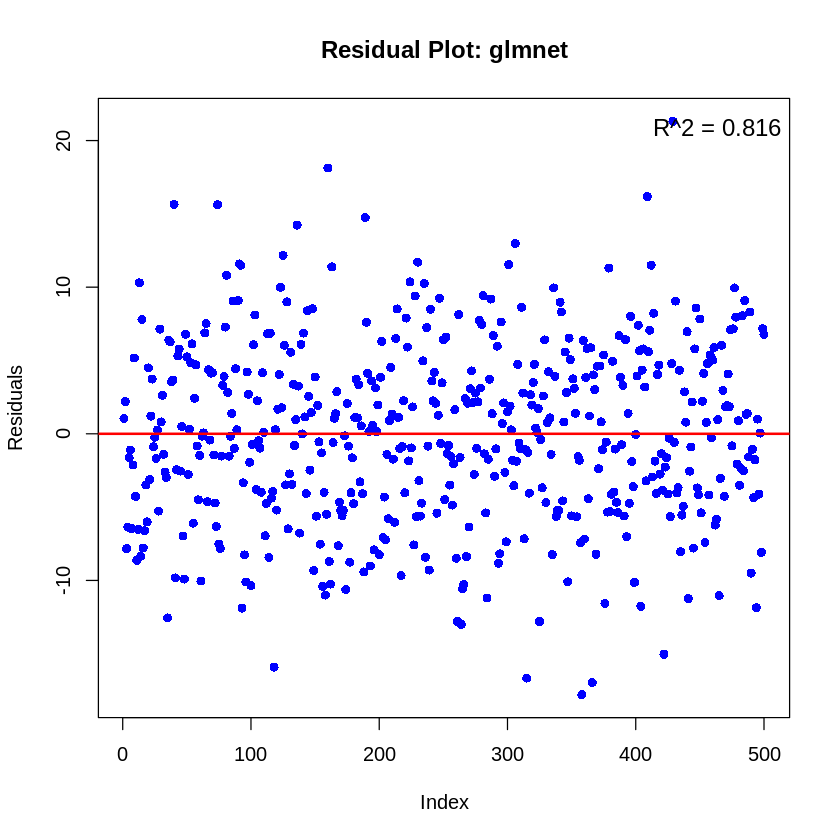

In [17]:
plot_residuals(y, y_pred_ista, r_squared_ista, title = "Residual Plot: ista")
plot_residuals(y, y_pred_fista, r_squared_fista, title = "Residual Plot: fista")
plot_residuals(y, y_pred_cgda, r_squared_cgda, title = "Residual Plot: cgda")
plot_residuals(y, y_pred_sla, r_squared_sla, title = "Residual Plot: sla")
plot_residuals(y, y_pred_pfa, r_squared_pfa, title = "Residual Plot: pfa")
plot_residuals(y, y_pred_glmnet, r_squared_glmnet, title = "Residual Plot: glmnet")